In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from scipy import stats
import utils_last_session as utils
import seaborn as sns
import pingouin as pg
import matplotlib.cm as cm

import statsmodels.stats.power as smp
from statsmodels.stats.anova import AnovaRM


from natsort import index_natsorted

# plt.rcParams['font.family'] = 'Times New Roman'


path_figs = "./Figs/"

seq_length = 7 #Length of sequences

windowSizes = [1, 2, 3, 7]

digit_change = [2,3,4]

fingers = ['1', '2', '3', '4', '5'] #mapping of fingers to numbers

iti = 3000   #Inter trial interval
execTime = 10000 # msecs for each trial maximum
precueTime_interval = [600, 1000] # msecs for planning before movement 
hand = 2 #left or right hand

# total_sub_num = 10
sub_nums = [2,3,4]



In [2]:
subjs_list = utils.read_dat_files_subjs_list(sub_nums)

for subj in subjs_list: ###Adding IPIs
    utils.add_IPI(subj)

subjs = pd.concat(subjs_list) ###Merging all subjs into one dataframe
subjs.reset_index(inplace=True, drop=True)

subjs_presses = utils.finger_melt(subjs).rename(columns={'isError' : 'isTrialError'})

subjs['condition'] = subjs.apply(utils.seq_condition, axis=1)
subjs_presses['condition'] = subjs_presses.apply(utils.seq_condition, axis=1)

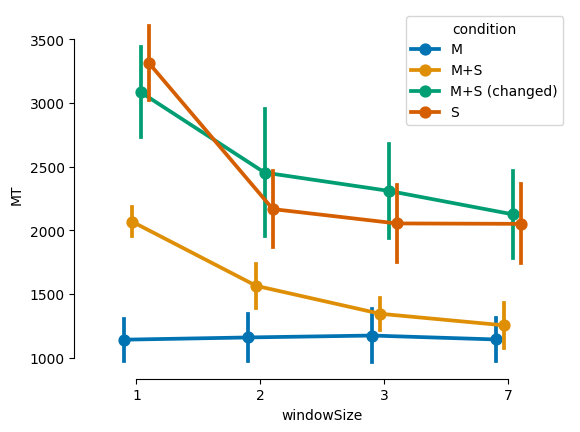

In [3]:
subjs_correct = utils.remove_error_trials(subjs)

subjs_grouped = subjs_correct.groupby(['SubNum', 'condition', 'windowSize']).agg({
    'MT': 'median'
}).reset_index()

sns.pointplot(data = subjs_grouped, x = 'windowSize', y = 'MT', hue = 'condition', errorbar='se',
              dodge = 0.2, palette='colorblind')
sns.despine(trim=True)

plt.show()

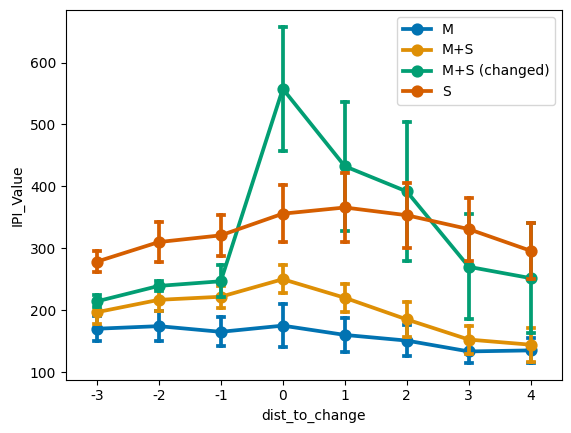

In [15]:
lookback_window = 7
presses_correct = utils.remove_error_trials_presses(subjs_presses)

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

for condition, data in presses_correct.groupby('condition'):
    if condition == 'M+S (changed)':
        data['dist_to_change'] = data['N'] - 1 - data['digitChangePos']
        data = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]

    else:
        datas = {}
        for digitpos in digit_change:
            data['dist_to_change'] = data['N'] - 1 - digitpos
            data_new = data[data['dist_to_change'].isin(range(-1 * lookback_window + 1, lookback_window))]
            datas[digitpos] = data_new
        
        data = pd.concat(list(datas.values()), ignore_index=True)
    
    data = data.groupby(['SubNum', 'dist_to_change']).agg({
        'IPI_Value': 'median'
    }).reset_index()

    sns.pointplot(data = data, x = 'dist_to_change', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1, 
                  label = condition)

            


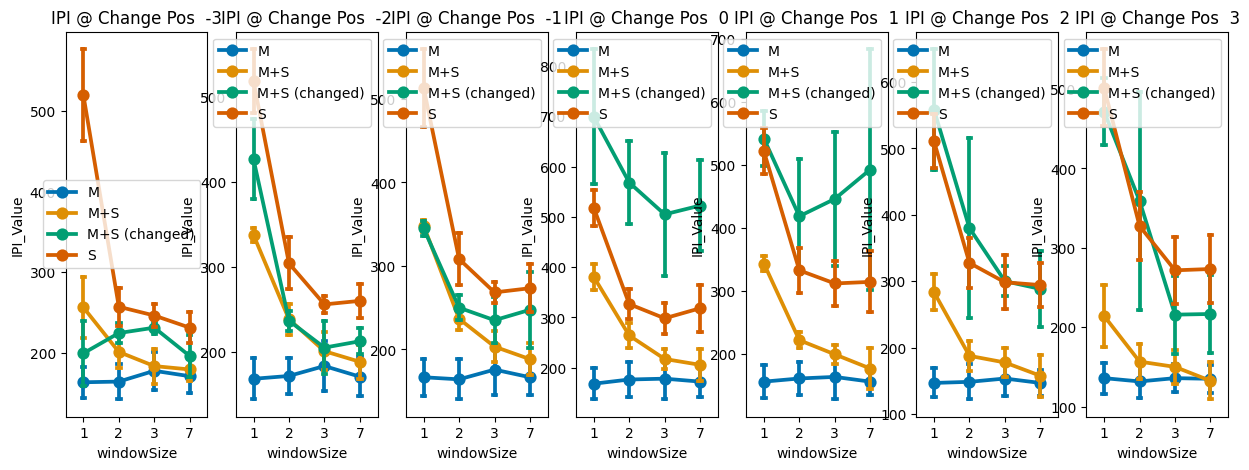

In [19]:
lookback_window = 4
presses_correct = utils.remove_error_trials_presses(subjs_presses)

#set palette colors
palette = sns.color_palette("colorblind", 4)
sns.set_palette(palette)

fig , axs = plt.subplots(ncols = lookback_window * 2 - 1, figsize = (15, 5))

for lookahead in range(-lookback_window + 1, lookback_window):

    for condition, data in presses_correct[presses_correct['N'].isin(
        pos + 1 + lookahead for pos in digit_change)].groupby('condition'):

        if condition == 'M+S (changed)':
            data = data[(data['digitChangePos'] + 1 + lookahead) == (data['N'])]


        data = data.groupby(['SubNum', 'windowSize']).agg({
            'IPI_Value': 'median'
        }).reset_index()

        ax_ind = lookahead + lookback_window - 1
        sns.pointplot(data = data, x = 'windowSize', y = 'IPI_Value', errorbar='se', dodge = True, capsize = 0.1,
                        label = condition, ax = axs[ax_ind])
        axs[ax_ind].set_title(f'IPI @ Change Pos  {lookahead}')


            
